## 导入库

In [4]:
import tensorflow as tf
tf.enable_eager_execution()
tfe = tf.contrib.eager # 某些符号的简写
tf.__version__

'1.10.0'

## 函数的衍生物
TensorFlow提供用于自动微分的API - 计算函数的派生。 更接近模仿数学的方法是将计算封装在Python函数中，比如f，并使用tfe.gradients_function创建一个函数，该函数根据参数计算f的导数。 如果您熟悉autograd以区分numpy函数，那么这将是熟悉的。 例如：

In [7]:
from math import pi

def f(x):
    return tf.square(tf.sin(x))
assert f(pi/2).numpy() == 1.0

#grad_f将返回f的导数列表
#＃关于其论点参数。由于f（）只有一个参数，
#grag_f将返回包含单个元素的列表。
grad_f = tfe.gradients_function(f)
print((grad_f(pi/2)[0]).numpy())
assert tf.abs(grad_f(pi/2)[0]).numpy() < 1e-7

-8.742278e-08


### 高阶梯度

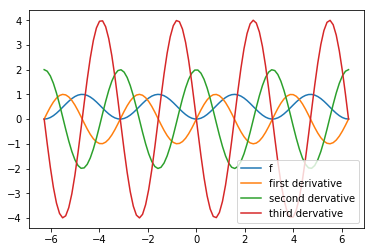

In [10]:
def f(x):
    return tf.square(tf.sin(x))

def grad(f):
    return lambda x:tfe.gradients_function(f)(x)[0]
x = tf.lin_space(-2*pi,2*pi,100) # 100 points between -2π and +2π

import matplotlib.pyplot as plt

plt.plot(x,f(x),label='f')
plt.plot(x,grad(f)(x),label='first derivative')
plt.plot(x,grad(grad(f))(x),label='second dervative')
plt.plot(x,grad(grad(grad(f)))(x),label='third dervative')
plt.legend()
plt.show()

## Gradient tapes

每个可区分的TensorFlow操作都具有相关的梯度函数。 例如，tf.square（x）的梯度函数将是一个返回2.0 * x的函数。 要计算用户定义函数的梯度（如上例中的f（x）），TensorFlow首先“记录”应用于计算函数输出的所有操作。 我们将此记录称为“磁带”。 然后，它使用该磁带和与每个基元操作相关联的梯度函数，以使用反向模式区分来计算用户定义函数的梯度。

由于操作是在执行时记录的，因此自然会处理Python控制流程（例如使用ifs和whiles）：

有时，将感兴趣的计算封装到函数中可能是不方便的。 例如，如果希望输出的梯度相对于函数中计算的中间值。 在这种情况下，稍微更详细但明确的tf.GradientTape上下文是有用的。 tf.GradientTape上下文中的所有计算都被“记录”。

In [29]:
x = tf.ones((2,2))
#Record operations for automatic differentiation
with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    y = tf.reduce_sum(x)
    z =  tf.multiply(y,y)

## Use the same tape to compute the derivative of z with respect to the
# intermediate value y.
dz_dy = t.gradient(z,y)
assert dz_dy.numpy() == 8.0 # 2*y  == 2*4

# Derivative of z with respect to the original input tensor x
dz_dx = t.gradient(z,x)
for i in [0,1]:
    for j in [0,1]:
        assert dz_dx[i][j].numpy() == 8.0

## 高阶梯度

记录GradientTape上下文管理器内部的操作以实现自动区分。 如果在该上下文中计算梯度，则也记录梯度计算。 因此，完全相同的API也适用于高阶梯度。 例如：

In [32]:
x = tf.constant(1.0)

with tf.GradientTape() as t:
    with tf.GradientTape() as t2:
        t2.watch(x)
        y = x*x*x
    dy_dx = t2.gradient(y,x)
d2y_dx2 = t.gradient(dy_dx,x)

assert dy_dx.numpy() == 3.0
assert d2y_dx2.numpy() == 6.0